Installation of `torch_tutor`

In [1]:
!pip install torch-tutor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Torch-Tutor Tutorial :

In tis Notebook we will see how to use torch_tutor easily.

First let us check if we have any GPU connected or not. If connected, then how much space is allocated.

In [2]:
!nvidia-smi

Sat Jul  9 05:01:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Now we have to download the data from Kaggle . Upload the kaggle API i.e. `kaggle.json` in the `/content/` folder.

The following cell of bash commands will download and prepared file directory.

In [3]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alxmamaev/flowers-recognition
!unzip -q /content/flowers-recognition.zip

 97% 217M/225M [00:06<00:00, 32.1MB/s]
100% 225M/225M [00:06<00:00, 38.6MB/s]


## 1. Dataset :

Then we'll split the data into training and validation set.

In [4]:
from torch.utils.data import Dataset, random_split
from torchvision.transforms import ToTensor
from glob import glob
from PIL import Image

Annotating class labels

In [5]:
class_names = {"daisy": 0, "dandelion": 1, "rose": 2, "sunflower": 3, "tulip": 4}

Preparing Flower Dataset and loading it.

In [6]:
class DS(Dataset):

    def __init__(self, dir):
        self.dir = glob(f"{dir}/*/*jpg")

    def __len__(self):
        return len(self.dir)

    def __getitem__(self, index):
        path = self.dir[index]
        label = class_names[path.split("/")[1]]
        image = Image.open(path)
        image = image.resize((224, 224))
        image = ToTensor()(image)

        return image, label

ds = DS("flowers")

Now splitting the dataset into train and validation set.

In [7]:
train_ds, val_ds = random_split(ds, [3000, 1317])

## 2. Model :     

Now we will prepare the model and call it.

The model in here is basically vgg11 with a last layer of 100 neurons outputs.

In [8]:
import torch.nn as nn
from torchvision.models import vgg11

In [9]:
class FlowerNN(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.net = nn.Sequential(
        vgg11(),
        nn.Linear(1000, num_classes)
    )

  def forward(self, x):
    return self.net(x)
print("Model")

model = FlowerNN(5)

Model


Now `torch_tutor` comes into the GAME.

In [10]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch_tutor.core.trainer import Trainer
from torch_tutor.core.callbacks import CallBack

In [11]:
callback = CallBack(tracker = "accuracy", on = "validation")
trainer = Trainer(train_ds, model, "cuda")
trainer.compile(Adam, CrossEntropyLoss(), metrics = ["accuracy", "precision", "recall"],
                optimizer_hparams={"lr": 0.0001})
trainer.train(batch_size=32, num_epochs=20, validation_set = val_ds, callback = callback)

Epoch : 1 :
[Step 0] : {'accuracy': 0.25, 'precision': 0.316106, 'recall': 0.25, 'loss': 1.611075}
[Step 10] : {'accuracy': 0.28125, 'precision': 0.161797, 'recall': 0.28125, 'loss': 1.600428}
[Step 20] : {'accuracy': 0.21875, 'precision': 0.047852, 'recall': 0.21875, 'loss': 1.610849}
[Step 30] : {'accuracy': 0.15625, 'precision': 0.03125, 'recall': 0.15625, 'loss': 1.609197}
[Step 40] : {'accuracy': 0.125, 'precision': 0.015625, 'recall': 0.125, 'loss': 1.617031}
[Step 50] : {'accuracy': 0.09375, 'precision': 0.130435, 'recall': 0.09375, 'loss': 1.674893}
[Step 60] : {'accuracy': 0.25, 'precision': 0.083333, 'recall': 0.25, 'loss': 1.589429}
[Step 70] : {'accuracy': 0.34375, 'precision': 0.170673, 'recall': 0.34375, 'loss': 1.549553}
[Step 80] : {'accuracy': 0.5625, 'precision': 0.614522, 'recall': 0.5625, 'loss': 1.307852}
[Step 90] : {'accuracy': 0.21875, 'precision': 0.223462, 'recall': 0.21875, 'loss': 1.464162}
Execution Time : 32.714566 seconds
Training scores : 
   accuracy  p

We can see NICE monitoring of resuts.

Let's visualize the training reports.

In [12]:
import matplotlib.pyplot as plt

In [14]:
# Train Data Report
trainer.train_report.head()

,accuracy,precision,recall,loss
0,0.256384,0.160407,0.256384,1.567555
1,0.442204,0.414715,0.442204,1.255708
2,0.524194,0.557211,0.524194,1.132585
3,0.607527,0.667225,0.607527,1.000443
4,0.674395,0.715013,0.674395,0.857762


In [15]:
# Validation Data Report
trainer.val_report.head()

,accuracy,precision,recall,loss
0,0.373476,0.202916,0.373476,1.420675
1,0.500000,0.433037,0.500000,1.152855
2,0.559451,0.620747,0.559451,1.059325
3,0.647104,0.671682,0.647104,0.869663
4,0.657774,0.697384,0.657774,0.872598


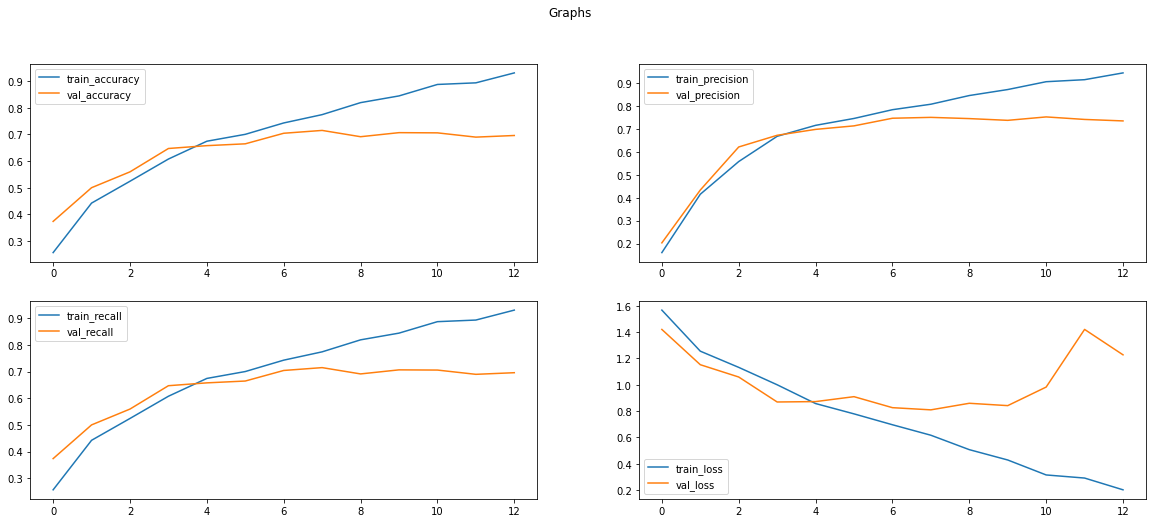

In [13]:
fig, ax = plt.subplots(2,2, figsize=(20, 8))
plt.suptitle("Graphs")
for i, name in enumerate(trainer.train_report.columns):
  plt.subplot(2,2,i+1)
  plt.plot(trainer.train_report[name], label=f"train_{name}")
  plt.plot(trainer.val_report[name], label=f"val_{name}")
  plt.legend()
plt.show()


If you get any errors while running the code, please make a PR.

Thanks for Visiting!!!

If you like the project, do ⭐

Also follow me on [GitHub](https://github.com/sagnik1511) , [Kaggle](https://kaggle.com/sagnik1511) , [LinkedIn](https://linkedin.com/in/sagnik1511)